    https://sdsawtelle.github.io/blog/output/shooting-method-ode-numerical-solution.html

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#import snips as snp
#snp.prettyplot(matplotlib)
from scipy.optimize import least_squares
from scipy.integrate import ode

%matplotlib inline

    ...Then we will write a wrapper that takes an initial value z⃗ (0) and calls the Runge-Kutta algorithm repeatedly to integrate across the full domain This function will return a list of z⃗ values which is the integrated solution for the discretized points in the domain. Finally we will write an optimization wrapper that actually solves the problem i.e. finds the optimal value for y′(0)=(z⃗ (0)) where loss is the squared error between the propagated y′(L) and the true y′(L)...

        z⃗ = [y, y']
        f(x,z⃗ ) = [y', -(1/A) * dA/dx * y']
        z⃗ (0) = [Te, ?]
        z⃗ (L) = [?, pc/k*A(L)]

In [19]:
#seems unneccessary here? Possibly needed to work with specific function
def compute_area_areaprime(x):
    """
    Compute the area and it's derivative as a function of independent variable x, return them as a vector.
    
    :param x: independent variable, the domain of the problem is x=0 to L
    :return: a 2-vec holding [A, dA/dx].
    """
    return [10, 0]  # Rectangle geometry

In [20]:
def compute_zprime(x, z, areafunction):
    """
    Compute the value of the vector z's derivative at a point given the value of the vector function z and the
    independent variable x. The form of this calculation is specified by the vector ODE. Return a vector for the
    derivative.
    
    :param x: indpendent variable, the domain of the problem is x=0 to L
    :param z: 2-vec of the variable representing system of equations, z = [y, y']
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :return: 2-vec of values for z' = f(x, z)
    """
    zprime_0 = z[1]
    area, areaprime = areafunction(x)
    zprime_1 = - areaprime/area * z[1]
    return [zprime_0, zprime_1]

In [21]:
def integrate_over_domain(z_at_0, integrator, areafunction, length=10, step=0.1, silent=True):
    """
    Call runge-kutta repeatedly to integrate the vector function z over the full domain (specified by length). Return
    a list of 2-vecs which are the value of the vector z at every point in the domain discretized by 'step'. Note that
    runge-kutta object calls x as "t" and z as "y".
    
    :param z_at_0: the value of the vector z=[y, y'] at the left boundary point. should be list or array.
    :param integrator: the runge-kutta numerical integrator object
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :param length: the length of the domain to integrate on (length=L=10 here)
    :param step: the step size with which to discretize the domain
    :param silent: bool indicating whether to print the progress of the integrator
    :return: array of 2-vecs - the value of vector z obtained by integration for each point in the discretized domain.
    """
    initial_conditions = z_at_0
    integrator.set_initial_value(initial_conditions, t=0)  # Set the initial values of z and x
    integrator.set_f_params(areafunction)
    dt = step

    xs, zs = [], []
    while integrator.successful() and integrator.t <= length:
        integrator.integrate(integrator.t + dt) # Integrate next timestep t+dt
        xs.append(integrator.t)
        zs.append([integrator.y[0], integrator.y[1]])
        if not silent:
            print("Current x and z values: ", integrator.t, integrator.y)
    return xs, zs

In [26]:
def solve_bvp_pj(y_at_0, yprime_at_length, areafunction, length=10, step=0.1, silent=True):
    """
    Numerically find the value for y'(0) that gives us a propagated (integrated) solution matching most closely with
    with other known boundary condition y'(L) which is proportional to the power dissipated by the junction.
    
    :param y_at_0: the known boundary condition on y for the left point.
    :param yprime_at_length: the known boundary condition on y' for the right point
    :param areafunction: a function that takes x and gives back a 2-vec [A(x), dA(x)/dx]
    :param length: the length of the domain to integrate on
    :param step: the step size with which to discretize the domain
    :param silent: bool indicating whether to print the progress of the integrator
    :return: the optimized estimate of y' at the left boundary point giving the most accurate integrated solution.
    """
    integrator = ode(compute_zprime).set_integrator("dopri5")
    z_at_0 = [y_at_0, 0.5]  # Make an initial guess for yprime at x=0
    
    def residuals(yprime_at_0, y_at_0, yprime_at_length):
        # Use RK to compute [y, y'] over the domain given the values for y, y' at the boundary
        z_at_0 = [y_at_0, yprime_at_0]
        xs, zs = integrate_over_domain(z_at_0, integrator, areafunction)
        yprime_at_length_integrated = np.array(zs)[-1, 1]

        # Return the difference between y'(L) found by numerical integrator and the true value
        return yprime_at_length - yprime_at_length_integrated

    yprime_at_0_guess = 0.2
    lsq = least_squares(residuals, yprime_at_0_guess, args=(y_at_0, yprime_at_length), loss="soft_l1")
    yprime_at_0_estimate = lsq.x[0]
    return yprime_at_0_estimate

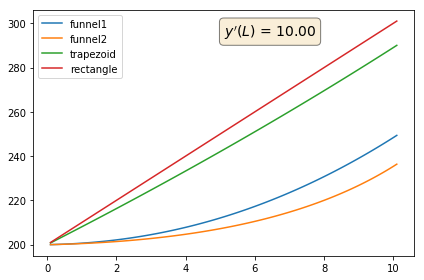

In [27]:
areafuncs = {"funnel1": lambda x: [20/(x+2) - 0.166, -20/(x+1)**2],
             "funnel2": lambda x: [10/(x+1) - 0.59, -10/(x+1)**2],
             "trapezoid": lambda x: [10-0.2*x, -0.2],
             "rectangle": lambda x: [10, 0]
             }
integrator = ode(compute_zprime).set_integrator("dopri5")
yprime_at_length = 10
y_at_0 = 200
fig, ax = plt.subplots()
#snp.labs("x (nm)", "T (K)", "Quasi-1D, Steady State, Heat Eqn")
for nm, areaf in areafuncs.items():
    integrator.set_initial_value([y_at_0, 0.5], t=0)  # Set the initial values of z and x
    integrator.set_f_params(areaf)
    yprime_at_0_estimate = solve_bvp_pj(y_at_0, yprime_at_length, areaf)
    xs, zs = integrate_over_domain([y_at_0, yprime_at_0_estimate], integrator, areaf)
    ax.plot(xs, np.array(zs)[:,0], label=nm)

ax.legend(loc="best")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.5, 0.95, "$y'(L)$ = %.2f" % (yprime_at_length,), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()